# Определение возраста покупателей

<b> Описание проекта </b>

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255.)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В датасете 7591 наблюдения, пропусков нет. Минимальный возраст - 1 гол, максимальный 100 лет.

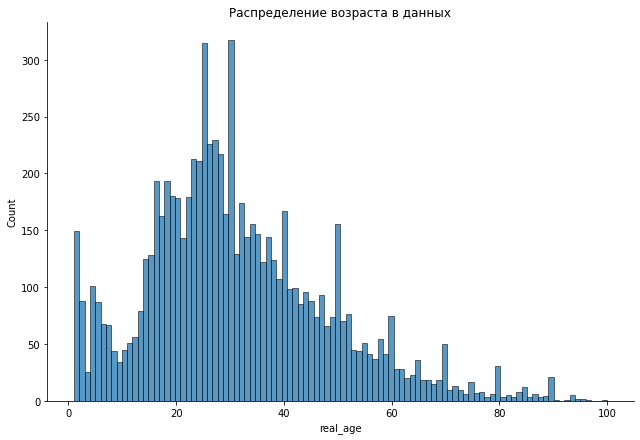

In [6]:
sns.displot(labels['real_age'], height=6, aspect=1.5, bins=100)
plt.title('Распределение возраста в данных')
plt.show()

Главным образом в данных содержатся фото людей от 16 до 55 лет. Можем предположить, что пики появились из-за округления возраста до юбилейного в датасете. На учейку ниже это видно

Много младенцев

In [37]:
window = 10
for i in np.arange(0, 95, window):
    print('Диапазон возраста: ',i, i+window)
    print(labels.loc[(labels['real_age']>=i) & (labels['real_age']<i+window)].value_counts('real_age').head(1))

Диапазон возраста:  0 10
real_age
1    149
dtype: int64
Диапазон возраста:  10 20
real_age
16    193
dtype: int64
Диапазон возраста:  20 30
real_age
25    315
dtype: int64
Диапазон возраста:  30 40
real_age
30    317
dtype: int64
Диапазон возраста:  40 50
real_age
40    167
dtype: int64
Диапазон возраста:  50 60
real_age
50    156
dtype: int64
Диапазон возраста:  60 70
real_age
60    75
dtype: int64
Диапазон возраста:  70 80
real_age
70    50
dtype: int64
Диапазон возраста:  80 90
real_age
80    31
dtype: int64
Диапазон возраста:  90 100
real_age
90    21
dtype: int64


In [44]:
imgs, ages = next(gen_flow)

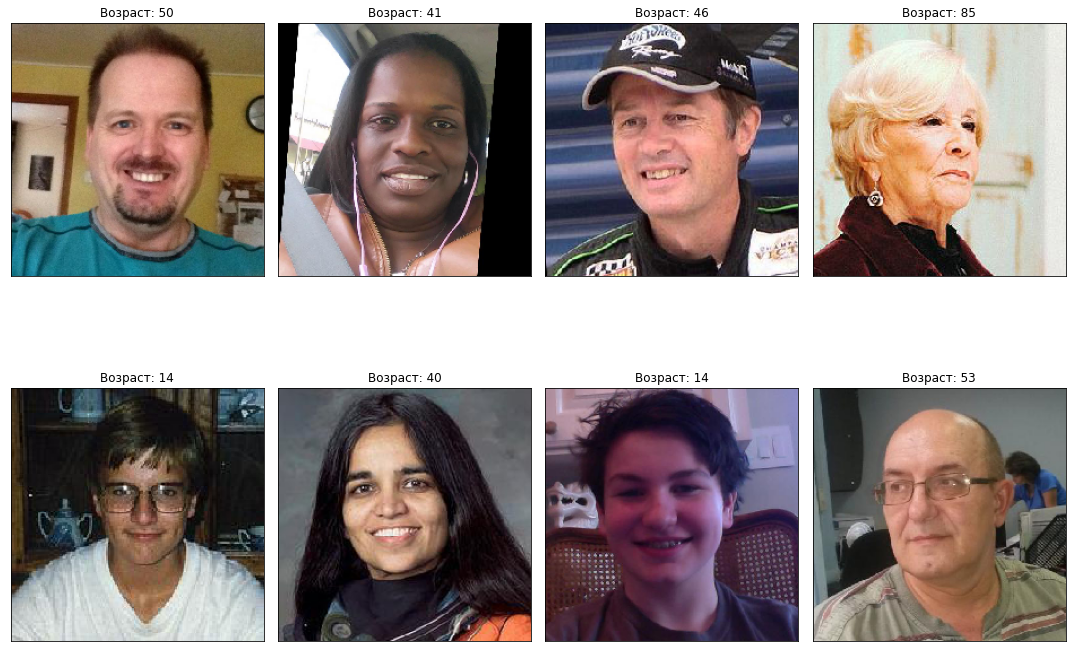

In [45]:
fig = plt.figure(figsize=(15,15))
for i in range(8):
    fig.add_subplot(2, 4,i+1)
    plt.title(f"Возраст: {ages[i]}")
    plt.imshow(imgs[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Визуально всё в порядке, реальные фотографии людей с корректным возрастом. Те пики на графике (округление возраста), которые мы обсуждали выше, могут внести "шум" в обучение. В итоге модель станет чаще подразумевать не конкретный возраст, а возрастную группу. Что неплохо для задачи по лучшему предложению для разных возрастных группы, но не мало подходит для контроля продажи алкоголя несовершеннолетним

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25)

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=1)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=1) 
    return test_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-06-29 09:45:16.503522: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-29 09:45:16.927315: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 58s - loss: 235.2096 - mae: 10.9786 - val_loss: 747.7181 - val_mae: 22.4631
Epoch 2/10
178/178 - 42s - loss: 61.4956 - mae: 5.9485 - val_loss: 597.8686 - val_mae: 19.4709
Epoch 3/10
178/178 - 42s - loss: 32.4235 - mae: 4.3924 - val_loss: 337.7812 - val_mae: 13.7912
Epoch 4/10
178/178 - 40s - loss: 20.2752 - mae: 3.5042 - val_loss: 156.2339 - val_mae: 9.2735
Epoch 5/10
178/178 - 39s - loss: 16.2214 - mae: 3.1324 - val_loss: 84.8501 - val_mae: 6.9423
Epoch 6/10
178/178 - 40s - loss: 13.0265 - mae: 2.7822 - val_loss: 67.3464 - val_mae: 6.2223
Epoch 7/10
178/178 - 43s - loss: 10.5032 - mae: 2.4908 - val_loss: 74.4495 - val_mae: 6.4330
Epoch 8/10
178/178 - 43s - loss: 8.9196 - mae: 2.2877 - val_loss: 71.3557 - val_mae: 6.4247
Epoch 9/10
178/178 - 43s - loss: 8.6065 - mae: 2.2384 - val_loss: 67.7670 - val_mae: 6.2788
Epoch 10/10
178/178 - 44s - loss: 7.9939 - mae: 2.1221 - val_loss: 68.6371 - val_mae: 6.1963
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 68.6371 - mae: 6.1963
Test MAE: 6.1963




```

## Анализ обученной модели


Предобученная модель ResNet50, дотюненная на заданом датасете показала требуемое значение метрики уже на 5 эпохе.

По окончании 10 эпох МАЕ равен 6.1963

При этом, нам даже не потребовалось проводить аугментацию данных, что хорошо для увеличения скорости обучения. .

Таким образом задачи, поставленные заказчиком, выполнены

Модель хорошо решает задачу выявления возрастных групп, что позволит сделать преложение более адресным.

Задача контроля за продажей алкоголя несовершеннолетним не может быть доверена модели ввиду средней ошибки в ~6 лет.

